# Exploration Data Analisys for World Bank datasets

В ходе данного занятия мы подготовить EDA для датасета **World Bank** и подготовим все необходимое для реализации ETL.

**Данные:**

[World Bank Indicator Data](https://data.worldbank.org/indicator) - Данные социально-экономических индикаторов для стран по всему миру. Как пример индикаторов можно привести популяцию (население).

[World Bank Project Data](https://datacatalog.worldbank.org/dataset/world-bank-projects-operations) - Данные проектов различных стран начиная с 1947 года.

#### В ходе данного занятия мы пройдем следующие этапы:
**Извлечение данных из разных источников:**
- csv
- json
- Базы данных

**Преобразование данных**
- Обхединения данных из различных источников
- Отчистка данных
- Парсинг дат
- Заполнение пропусков
- Работа с дубликатами
- Удаление незначимых переменных
- Выбросы в данных

**Формирование выходной таблицы**
- Построим таблицу, которую можно использовать для обучения моделей

**Цель ноутбука**
- Подготовить несколько гипотез для этапа преобразования данных
- Подготовить скрипты для реализации ETL-пайплайна

## Imports

In [4]:
%load_ext autoreload
%autoreload 2

In [14]:
import os
import sys
import json
from encodings.aliases import aliases
from collections import defaultdict

sys.path.append('../')

import sqlite3
from sklearn.linear_model import LinearRegression
import chardet
import numpy as np
import pandas as pd
from pycountry import countries
import requests
import pandas as pd
from sqlalchemy import create_engine
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

## Посмотрим на данные

В данном разделе мы откроем все файлы и посмотрим на их содержимое

In [6]:
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/clear_data/s1w1_population_data_2006_2017.csv
data/clear_data/population_data_1990_2005.db
data/clear_data/population_data.csv
data/clear_data/rural_population_percent.csv
data/clear_data/population_data.db
data/clear_data/population_data.json
data/clear_data/gdp_data.csv
data/clear_data/projects_data.csv
data/clear_data/population_data.xml
data/clear_data/mystery.csv
data/clear_data/electricity_access_percent.csv


### Рассмотри файл `projects_data.csv`

In [7]:
df_projects = pd.read_csv('data/clear_data/projects_data.csv', dtype='str')
print(df_projects.shape)
df_projects.head()

(18248, 57)


,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,projectstatusdisplay,...,mjtheme3name,mjtheme4name,mjtheme5name,location,GeoLocID,GeoLocName,Latitude,Longitude,Country,Unnamed: 56
0,P162228,Other,World;World,RE,Investment Project Financing,IN,C,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,PE,Investment Project Financing,IN,NaN,Y,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Investment Project Financing,IN,A,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...,0002327546;0002328925;0002565340;0002565343;00...,Ogun State;Niger State;Abia State;Edo;Kebbi St...,7;10;5.41667;6.5;11.5;8,3.58333;6;7.5;6;4;10.5,NG;NG;NG;NG;NG;NG,NaN


In [8]:
# Считаем количество значений `null` в датафрейме
df_projects.isnull().sum()

id                              0
regionname                      0
countryname                     0
prodline                        0
lendinginstr                  246
lendinginstrtype              246
envassesmentcategorycode     5811
supplementprojectflg           53
productlinetype                 0
projectstatusdisplay            4
status                          4
project_name                    0
boardapprovaldate            1504
board_approval_month         1504
closingdate                  3349
lendprojectcost               125
ibrdcommamt                     0
idacommamt                      0
totalamt                        0
grantamt                        0
borrower                     5919
impagency                    6097
url                             0
projectdoc                  18248
majorsector_percent         18248
sector1                         0
sector2                      8721
sector3                     11761
sector4                     13872
sector5       

Очевидно, что есть большое количество пропущенных значений. Так например можно заметить, что в поле `countryname` значений не пропущено, а аналогичное поле `country` имеет 14045 пропущенных значений.

In [9]:
columns = df_projects.columns
for column in columns:
    if df_projects.isnull().sum()[column] / df_projects.shape[0] > 0.2:
        df_projects.drop(column, axis=1, inplace=True)

In [10]:
df_projects.isnull().sum()

id                         0
regionname                 0
countryname                0
prodline                   0
lendinginstr             246
lendinginstrtype         246
supplementprojectflg      53
productlinetype            0
projectstatusdisplay       4
status                     4
project_name               0
boardapprovaldate       1504
board_approval_month    1504
closingdate             3349
lendprojectcost          125
ibrdcommamt                0
idacommamt                 0
totalamt                   0
grantamt                   0
url                        0
sector1                    0
sector                   638
mjsector                 638
theme1                     0
dtype: int64

Сохраним данный файл

In [12]:
df_projects.to_csv('data/preprocess_data/projects_data.csv', index=False)

### Рассмотрим файл `df_population.csv`

In [16]:
df_population = pd.read_csv('data/clear_data/population_data.csv', dtype=str)
print(df_population.shape)
df_population.head()

(264, 63)


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211,55438,56225,56695,57032,57360,...,101453,101669,102053,102577,103187,103795,104341,104822,105264,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351,9166764,9345868,9533954,9731361,9938414,...,28004331,28803167,29708599,30696958,31731688,32758020,33736494,34656032,35530081,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182,5753024,5866061,5980417,6093321,6203299,...,22549547,23369131,24218565,25096150,25998340,26920466,27859305,28813463,29784193,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800,1659800,1711319,1762621,1814135,1864791,...,2927519,2913021,2905195,2900401,2895092,2889104,2880703,2876101,2873457,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411,14375,15370,16412,17469,18549,...,84462,84449,83751,82431,80788,79223,78014,77281,76965,NaN


In [17]:
df_population = df_population.drop('Unnamed: 62', axis=1)

In [18]:
df_population.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017'],
      dtype='object')

In [19]:
columns_1 = [
    'Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
    '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
    '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
    '1978', '1979', '1980'
]
columns_2  =  [
    'Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
    '1981', '1982', '1983', '1984', '1985', '1986',
    '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
    '1996', '1997', '1998', '1999', '2000'
]
columns_3   = [
    'Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
    '2001', '2002', '2003', '2004',
    '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
    '2014', '2015', '2016', '2017'
]

In [20]:
df_population[columns_1].to_json('data/preprocess_data/population_data_1960_1980.json', orient='records')

In [38]:
engine_sqlite3 = create_engine('sqlite:///data/preprocess_data/population_data.db')
engine_sqlite3.raw_connection()
df_population[columns_2].to_sql('population_data_1981_2000', engine_sqlite3, if_exists='replace', index=False)

264

In [40]:
engine_sqlite3.table_names()

/tmp/ipykernel_2803/3785254850.py:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  engine_sqlite3.table_names()


['population_data', 'population_data_1981_2000']

In [41]:
df_population[columns_3].to_csv('data/preprocess_data/population_data_2001_2017.csv', index=False)

In [68]:
df_indicator = pd.read_csv('data/clear_data/population_data.csv')
df_indicator.drop(['Unnamed: 62'], axis=1, inplace=True)

df_projects = pd.read_csv('data/preprocess_data/projects_data.csv', dtype=str)

In [46]:
print(df_projects.shape)
df_projects.head()

(18248, 24)


,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,supplementprojectflg,productlinetype,projectstatusdisplay,status,...,lendprojectcost,ibrdcommamt,idacommamt,totalamt,grantamt,url,sector1,sector,mjsector,theme1
0,P162228,Other,World;World,RE,Investment Project Financing,IN,N,L,Active,Active,...,"500,000",0,0,0,"500,000",http://projects.worldbank.org/P162228?lang=en,!$!0,NaN,NaN,!$!0
1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Investment Project Financing,IN,N,L,Active,Active,...,"200,000,000",0,"200,000,000","200,000,000",0,http://projects.worldbank.org/P163962?lang=en,!$!0,NaN,NaN,!$!0
2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,PE,Investment Project Financing,IN,Y,L,Active,Active,...,"50,000,000",0,"58,330,000","58,330,000",0,http://projects.worldbank.org/P167672?lang=en,!$!0,NaN,NaN,!$!0
3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Investment Project Financing,IN,N,L,Active,Active,...,"50,000,000",0,"20,000,000","20,000,000",0,http://projects.worldbank.org/P158768?lang=en,!$!0,NaN,NaN,!$!0
4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,N,L,Active,Active,...,"100,000,000",0,"100,000,000","100,000,000",0,http://projects.worldbank.org/P161364?lang=en,Social Protection!$!63!$!SA,Social Protection;Social Protection;Other Indu...,Social Protection;Social Protection;Industry; ...,!$!0


In [48]:
df_indicator[['Country Name', 'Country Code']].drop_duplicates()

,Country Name,Country Code
0,Aruba,ABW
1,Afghanistan,AFG
2,Angola,AGO
3,Albania,ALB
4,Andorra,AND
...,...,...
259,Kosovo,XKX
260,"Yemen, Rep.",YEM
261,South Africa,ZAF
262,Zambia,ZMB


## Работа с полем `Country`
Стоит обратить внимание, что в файле `df_projects`, в столбце 'Country' значения не заполнены. 

Постановка проблемы:
- Файл `df_projects` содержит абревиатуры стран, в то время как файл `df_indicator` содержит названия и абревиатуры.

Намного проще объединять файлы с уникальными идентификарами. Поэтому приведем данные к одному виду.

In [69]:
df_projects['countryname'].unique()

array(['World;World',
       'Democratic Republic of the Congo;Democratic Republic of the Congo',
       "People's Republic of Bangladesh;People's Republic of Bangladesh",
       'Islamic  Republic of Afghanistan;Islamic  Republic of Afghanistan',
       'Federal Republic of Nigeria;Federal Republic of Nigeria',
       'Republic of Tunisia;Republic of Tunisia',
       'Lebanese Republic;Lebanese Republic',
       'Democratic Socialist Republic of Sri Lan;Democratic Socialist Republic of Sri Lan',
       'Nepal;Nepal', 'Kyrgyz Republic;Kyrgyz Republic',
       'Hashemite Kingdom of Jordan;Hashemite Kingdom of Jordan',
       'Republic of the Union of Myanmar;Republic of the Union of Myanmar',
       'Arab Republic of Egypt;Arab Republic of Egypt',
       'United Republic of Tanzania;United Republic of Tanzania',
       'Federal Democratic Republic of Ethiopia;Federal Democratic Republic of Ethiopia',
       'Burkina Faso;Burkina Faso',
       'Republic of Uzbekistan;Republic of Uzbekist

In [70]:
df_projects['Official Country Name'] = df_projects['countryname'].str.split(';').str.get(0)

In [71]:
country_not_found = [] 
project_country_abbrev_dict = defaultdict(str) 

# Итерируемся по всем возможным названиям стран
for country in df_projects['Official Country Name'].drop_duplicates().sort_values():
    try: 
        # Сопоставляем значениям ключа - уникальный код ISO
        project_country_abbrev_dict[country] = countries.lookup(country).alpha_3
    except:
        # Если такого кода нет, 
        print(country, 'country_not_found')
        country_not_found.append(country)

Africa country_not_found
Andean Countries country_not_found
Aral Sea country_not_found
Asia country_not_found
Caribbean country_not_found
Caucasus country_not_found
Central Africa country_not_found
Central America country_not_found
Central Asia country_not_found
Co-operative Republic of Guyana country_not_found
Commonwealth of Australia country_not_found
Democratic Republic of Sao Tome and Prin country_not_found
Democratic Republic of the Congo country_not_found
Democratic Socialist Republic of Sri Lan country_not_found
EU Accession Countries country_not_found
East Asia and Pacific country_not_found
Eastern Africa country_not_found
Europe and Central Asia country_not_found
Islamic  Republic of Afghanistan country_not_found
Kingdom of Swaziland country_not_found
Latin America country_not_found
Macedonia country_not_found
Mekong country_not_found
Mercosur country_not_found
Middle East and North Africa country_not_found
Multi-Regional country_not_found
Organization of Eastern Caribbean St

In [72]:
# Проверим есть ли название в файле df_projects
indicator_countries = df_indicator[['Country Name', 'Country Code']].drop_duplicates().sort_values(by='Country Name')

for country in country_not_found:
    if country in indicator_countries['Country Name'].tolist():
        print(country)

South Asia
St. Kitts and Nevis
St. Lucia
St. Vincent and the Grenadines
West Bank and Gaza
World


In [73]:
country_not_found_mapping = {
    'Co-operative Republic of Guyana': 'GUY',
    'Commonwealth of Australia':'AUS',
    'Democratic Republic of Sao Tome and Prin':'STP',
    'Democratic Republic of the Congo':'COD',
    'Democratic Socialist Republic of Sri Lan':'LKA',
    'East Asia and Pacific':'EAS',
    'Europe and Central Asia': 'ECS',
    'Islamic  Republic of Afghanistan':'AFG',
    'Latin America':'LCN',
    'Caribbean':'LCN',
    'Macedonia':'MKD',
    'Middle East and North Africa':'MEA',
    'Oriental Republic of Uruguay':'URY',
    'Republic of Congo':'COG',
    "Republic of Cote d'Ivoire":'CIV',
    'Republic of Korea':'KOR',
    'Republic of Niger':'NER',
    'Republic of Kosovo':'XKX',
    'Republic of Rwanda':'RWA',
    'Republic of The Gambia':'GMB',
    'Republic of Togo':'TGO',
    'Republic of the Union of Myanmar':'MMR',
    'Republica Bolivariana de Venezuela':'VEN',
    'Sint Maarten':'SXM',
    "Socialist People's Libyan Arab Jamahiriy":'LBY',
    'Socialist Republic of Vietnam':'VNM',
    'Somali Democratic Republic':'SOM',
    'South Asia':'SAS',
    'St. Kitts and Nevis':'KNA',
    'St. Lucia':'LCA',
    'St. Vincent and the Grenadines':'VCT',
    'State of Eritrea':'ERI',
    'The Independent State of Papua New Guine':'PNG',
    'West Bank and Gaza':'PSE',
    'World':'WLD',
}

In [74]:
project_country_abbrev_dict.update(country_not_found_mapping)

In [75]:
df_projects['Country Code'] = df_projects['Official Country Name'].apply(lambda x: project_country_abbrev_dict[x])

In [76]:
df_projects = df_projects[df_projects['Country Code'] != '']

## Обработка дат

In [77]:
df_projects.head(5)[['boardapprovaldate', 'board_approval_month', 'closingdate']]

,boardapprovaldate,board_approval_month,closingdate
0,2018-06-28T00:00:00Z,June,NaN
1,2018-06-28T00:00:00Z,June,2023-12-31T00:00:00Z
2,2018-06-28T00:00:00Z,June,NaN
3,2018-06-27T00:00:00Z,June,2023-06-28T00:00:00Z
4,2018-06-27T00:00:00Z,June,2023-05-31T00:00:00Z


In [84]:
df_projects['boardapprovaldate'] = pd.to_datetime(df_projects['boardapprovaldate'])
df_projects['closingdate'] = pd.to_datetime(df_projects['closingdate'])

In [82]:
df_projects.fillna('', inplace=True)

In [87]:
df_projects['approvalyear'] = pd.to_numeric(df_projects['boardapprovaldate'].dt.year)
df_projects['approvalday'] = pd.to_numeric(df_projects['boardapprovaldate'].dt.year)
df_projects['approvalweekday'] = pd.to_numeric(df_projects['boardapprovaldate'].dt.year)
df_projects['closingyear'] = pd.to_numeric(df_projects['closingdate'].dt.year)
df_projects['closingday'] = pd.to_numeric(df_projects['closingdate'].dt.year)
df_projects['closingweekday'] = pd.to_numeric(df_projects['closingdate'].dt.year)

# df_projects.drop(columns=['boardapprovaldate',  'closingdate'], inplace=True)

In [88]:
df_projects

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,supplementprojectflg,productlinetype,projectstatusdisplay,status,...,mjsector,theme1,Official Country Name,Country Code,approvalyear,approvalday,approvalweekday,closingyear,closingday,closingweekday
0,P162228,Other,World;World,RE,Investment Project Financing,IN,N,L,Active,Active,...,,!$!0,World,WLD,2018.0,2018.0,2018.0,NaN,NaN,NaN
1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Investment Project Financing,IN,N,L,Active,Active,...,,!$!0,Democratic Republic of the Congo,COD,2018.0,2018.0,2018.0,2023.0,2023.0,2023.0
2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,PE,Investment Project Financing,IN,Y,L,Active,Active,...,,!$!0,People's Republic of Bangladesh,BGD,2018.0,2018.0,2018.0,NaN,NaN,NaN
3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Investment Project Financing,IN,N,L,Active,Active,...,,!$!0,Islamic Republic of Afghanistan,AFG,2018.0,2018.0,2018.0,2023.0,2023.0,2023.0
4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,N,L,Active,Active,...,Social Protection;Social Protection;Industry; ...,!$!0,Federal Republic of Nigeria,NGA,2018.0,2018.0,2018.0,2023.0,2023.0,2023.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,P006578,Latin America and Caribbean,Republic of Chile;Republic of Chile,PE,Specific Investment Loan,IN,N,L,Closed,Closed,...,(Historic)Electric Power & Other Energy;(Histo...,!$!0,Republic of Chile,CHL,1948.0,1948.0,1948.0,1954.0,1954.0,1954.0
18244,P037451,Europe and Central Asia,Grand Duchy of Luxembourg;Grand Duchy of Luxem...,PE,Structural Adjustment Loan,AD,N,L,Closed,Closed,...,(Historic)Multisector;(Historic)Multisector,!$!0,Grand Duchy of Luxembourg,LUX,1947.0,1947.0,1947.0,1949.0,1949.0,1949.0
18245,P037362,Europe and Central Asia,Kingdom of Denmark;Kingdom of Denmark,PE,Structural Adjustment Loan,AD,N,L,Closed,Closed,...,(Historic)Multisector;(Historic)Multisector,!$!0,Kingdom of Denmark,DNK,1947.0,1947.0,1947.0,1949.0,1949.0,1949.0
18246,P037452,Europe and Central Asia,Kingdom of the Netherlands;Kingdom of the Neth...,PE,Structural Adjustment Loan,AD,N,L,Closed,Closed,...,(Historic)Multisector;(Historic)Multisector,!$!0,Kingdom of the Netherlands,NLD,1947.0,1947.0,1947.0,1948.0,1948.0,1948.0


In [89]:
df_projects.to_csv('data/preprocess_data/projects_data_Country_Date_repair.csv', index=False)

#### Почему некоторые поля `closingdate` могут быть пустыми?

## Заполнение данных

Прощенные значения

In [100]:
df_vvp = pd.read_csv('data/clear_data/gdp_data.csv')
df_vvp.drop('Unnamed: 62', axis=1, inplace=True)

In [102]:
print(df_vvp.shape)
df_vvp.head()

(264, 62)


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.791961e+09,2.498933e+09,2.467704e+09,2.584464e+09,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,1.019053e+10,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.026425e+10,2.061610e+10,1.921556e+10,1.946902e+10,2.081530e+10
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8.417804e+10,7.549239e+10,8.252614e+10,1.041158e+11,1.139232e+11,1.249125e+11,1.267302e+11,1.026212e+11,9.533720e+10,1.242094e+11
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.138693e+10,1.188368e+10,1.303935e+10
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09,3.012914e+09


In [103]:
df_vvp.isnull().sum()

Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960              140
                 ... 
2013               16
2014               17
2015               18
2016               23
2017               30
Length: 62, dtype: int64

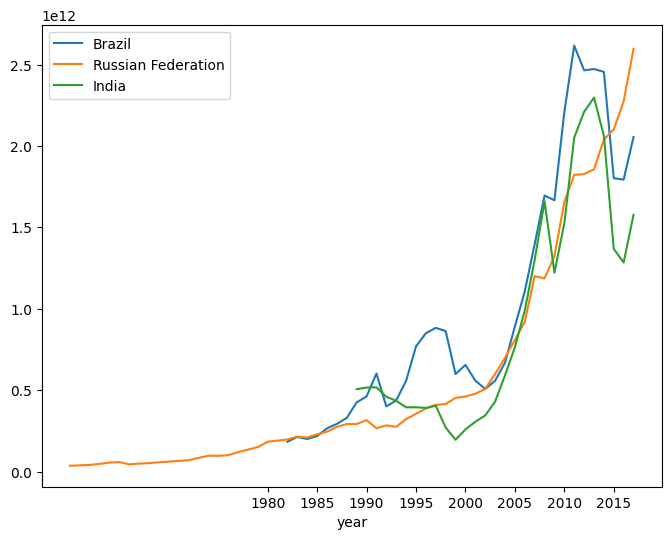

In [144]:
# put the data set into long form instead of wide
df_vvp_melt = pd.melt(df, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name='year', value_name='GDP')

def plot_results(column_name):
    # plot the results for Afghanistan, Albania, and Honduras
    fig, ax = plt.subplots(figsize=(8,6))

    df_vvp_melt[(df_vvp_melt['Country Name'] == 'Brazil') | 
            (df_vvp_melt['Country Name'] == 'Russian Federation') | 
            (df_vvp_melt['Country Name'] == 'India')].groupby('Country Name').plot('year', column_name, legend=True, ax=ax)
    ax.legend(labels=['Brazil', 'Russian Federation', 'India'])
    
plot_results('GDP')

In [145]:
df_vvp_melt['GDP_filled'] = df_vvp_melt.groupby('Country Name')['GDP'].transform(lambda x: x.fillna(x.mean()))

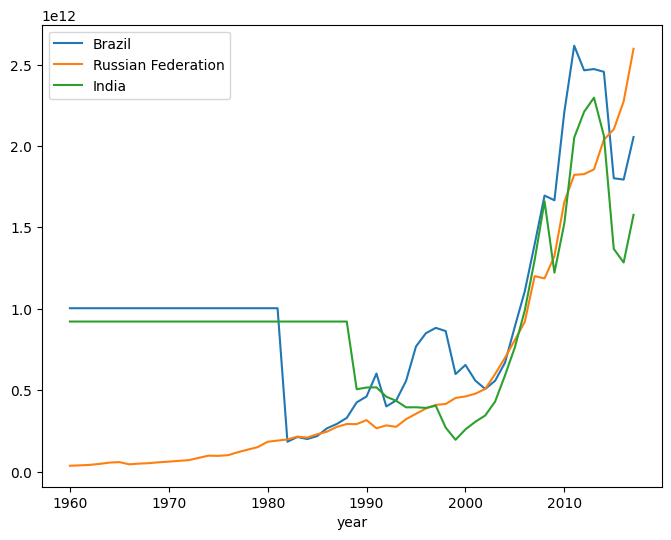

In [146]:
plot_results('GDP_filled')

In [147]:
df_vvp_melt['GDP_ff_bf'] = df_vvp_melt.sort_values('year').groupby('Country Name')['GDP'].fillna(method='ffill').fillna(method='bfill')

/tmp/ipykernel_2803/3796506838.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_vvp_melt['GDP_ff_bf'] = df_vvp_melt.sort_values('year').groupby('Country Name')['GDP'].fillna(method='ffill').fillna(method='bfill')


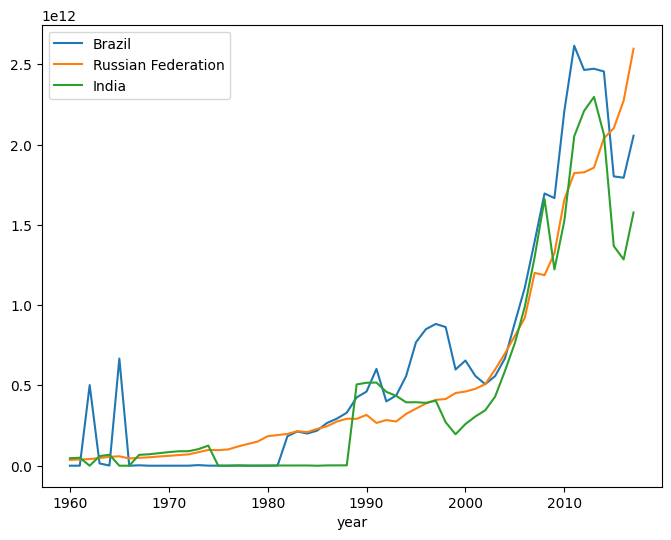

In [148]:
plot_results('GDP_ff_bf')

In [149]:
df_vvp_melt['GDP_ff_bf'].isnull().sum()

0

In [150]:
df_vvp_melt.head()

,Country Name,Country Code,Indicator Name,Indicator Code,year,GDP,GDP_filled,GDP_ff_bf
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,1960,NaN,2.036355e+09,1.916242e+09
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,1960,5.377778e+08,5.377778e+08,5.377778e+08
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,1960,NaN,3.847557e+10,1.857319e+10
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,1960,NaN,6.220172e+09,1.857319e+10
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,1960,NaN,1.501056e+09,1.857319e+10


## Переменные экономического сектора

Рассмотрим поле `sector1` и узнаем как изменить его, чтобы данные были чистыми

In [10]:
# Create a list of the unique values in sector1. Use the sort_values() and unique() pandas methods. 
# And then convert those results into a Python list
uniquesectors1 = df_projects['sector1'].sort_values().unique()
uniquesectors1

array(['!$!0', '(Historic)Agency reform!$!50!$!AG',
       '(Historic)Agricultural credit!$!100!$!AC', ...,
       'Workforce Development and Vocational Education!$!96!$!EW',
       'Workforce Development and Vocational Education!$!98!$!EW',
       'Workforce Development and Vocational Education!$!99!$!EW'],
      dtype=object)

In [12]:
# run this code cell to see the number of unique values
print('Number of unique values in sector1:', len(uniquesectors1))

Number of unique values in sector1: 2996


С этой переменной «сектор1» есть несколько проблем. Во-первых, есть значения с меткой '!$!0'. Их следует заменить на NaN.

Более того, каждое значение сектора1 заканчивается строкой из десяти или одиннадцати символов, например '!$!49!$!EP'. Некоторые сектора отображаются в списке дважды, например:
 «Другая промышленность; Торговля и услуги!$!70!$!ЫЗ',
 «Другая промышленность; Торговля и услуги!$!63!$!YZ',

Но похоже, что это на самом деле один и тот же сектор. Вам нужно будет удалить все, что находится за восклицательным знаком.

Многие значения переменной сектор1 начинаются с термина «(Исторический)». Попробуйте удалить и эту фразу.

### replace() method

В pandas вы можете использовать метод replace() для поиска текста и замены частей строки другой строкой. Если вы знаете точную строку, которую ищете, метод replace() не вызывает затруднений. Например, предположим, что вы хотите удалить строку «(Пробная версия)» из этих данных:

| data                     |
|--------------------------|
| '(Trial) Banking'        |
| 'Banking'                |
| 'Farming'                |
| '(Trial) Transportation' |

Вы можете использовать `df['data'].replace('(Trial'), '')` для замены (Trial) пустой строкой.


In [15]:
df_projects['sector1'] = df_projects['sector1'].replace('!$!0', np.nan)

df_projects['sector1'] = df_projects['sector1'].replace('!.+', '', regex=True)

df_projects['sector1'] = df_projects['sector1'].replace('^(\(Historic\))', '', regex=True)

print('Number of unique sectors after cleaning:', len(list(df_projects['sector1'].unique())))
print('Percentage of null values after cleaning:', 100 * df_projects['sector1'].isnull().sum() / df_projects['sector1'].shape[0])

Number of unique sectors after cleaning: 155
Percentage of null values after cleaning: 3.369883460589012


Сейчас существует 156 уникальных категориальных значений. Это лучше, чем 3060.

> ## Поиск выбросов

Рассмотрим набор данных Всемирного банка по ВВП и населению. Сначала посмотрим на данные с одномерной точки зрения, а затем с двухмерной точки зрения.

In [ ]:
df_vvp.head()

In [19]:
# read in the projects data set and do basic wrangling 
gdp = pd.read_csv('data/clear_data/gdp_data.csv')
gdp.drop(['Unnamed: 62', 'Country Code', 'Indicator Name', 'Indicator Code'], inplace=True, axis=1)
population = pd.read_csv('data/clear_data/population_data.csv')
population.drop(['Unnamed: 62', 'Country Code', 'Indicator Name', 'Indicator Code'], inplace=True, axis=1)


# Reshape the data sets so that they are in long format
gdp_melt = gdp.melt(id_vars=['Country Name'], 
                    var_name='year', 
                    value_name='gdp')

# Use back fill and forward fill to fill in missing gdp values
gdp_melt['gdp'] = gdp_melt.sort_values('year').groupby('Country Name')['gdp'].fillna(method='ffill').fillna(method='bfill')

population_melt = population.melt(id_vars=['Country Name'], 
                                  var_name='year', 
                                  value_name='population')

# Use back fill and forward fill to fill in missing population values
population_melt['population'] = population_melt.sort_values('year').groupby('Country Name')['population'].fillna(method='ffill').fillna(method='bfill')

# merge the population and gdp data together into one data frame
df_country = gdp_melt.merge(population_melt, on=('Country Name', 'year'))

# filter data for the year 2016
df_2016 = df_country[df_country['year'] == '2016']

# see what the data looks like
df_2016.head(10)

/tmp/ipykernel_1929/525204693.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_melt['gdp'] = gdp_melt.sort_values('year').groupby('Country Name')['gdp'].fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_1929/525204693.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  population_melt['population'] = population_melt.sort_values('year').groupby('Country Name')['population'].fillna(method='ffill').fillna(method='bfill')


,Country Name,year,gdp,population
14784,Aruba,2016,2.584464e+09,104822.0
14785,Afghanistan,2016,1.946902e+10,34656032.0
14786,Angola,2016,9.533720e+10,28813463.0
14787,Albania,2016,1.188368e+10,2876101.0
14788,Andorra,2016,2.877312e+09,77281.0
14789,Arab World,2016,2.500164e+12,406452690.0
14790,United Arab Emirates,2016,3.570451e+11,9269612.0
14791,Argentina,2016,5.548609e+11,43847430.0
14792,Armenia,2016,1.054614e+10,2924816.0
14793,American Samoa,2016,6.580000e+08,55599.0


Explore the data set to identify outliers using the Tukey rule.

<Axes: >

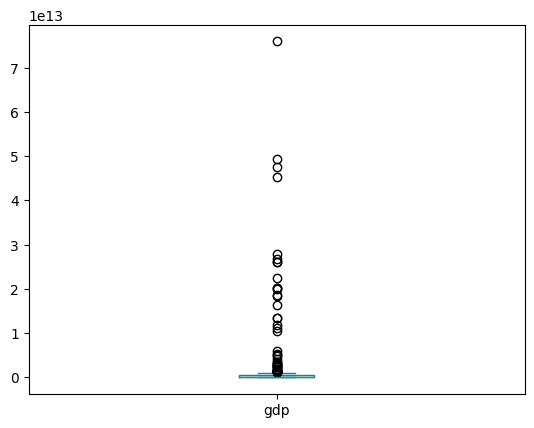

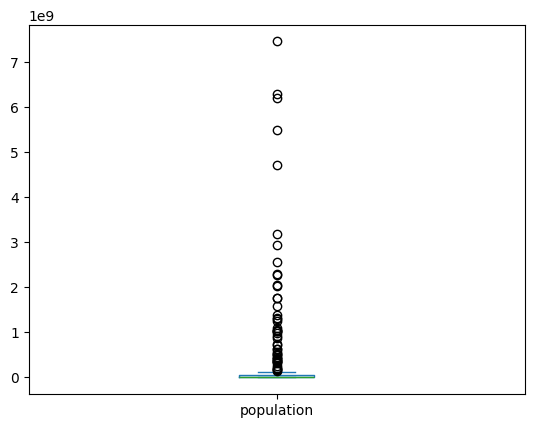

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Построим boxplot для данных популяции за 2016 год
df_2016.plot('population', kind='box')

# Построим boxplot для данных ввп за 2016 год
df_2016.plot('gdp', kind='box')

In [22]:
# Удалим строки из данных, которые имеют значения `CountryName` в списке non_countries
# Сохраняем результаты фильтра обратно в переменную df_2016

non_countries = ['World',
 'High income',
 'OECD members',
 'Post-demographic dividend',
 'IDA & IBRD total',
 'Low & middle income',
 'Middle income',
 'IBRD only',
 'East Asia & Pacific',
 'Europe & Central Asia',
 'North America',
 'Upper middle income',
 'Late-demographic dividend',
 'European Union',
 'East Asia & Pacific (excluding high income)',
 'East Asia & Pacific (IDA & IBRD countries)',
 'Euro area',
 'Early-demographic dividend',
 'Lower middle income',
 'Latin America & Caribbean',
 'Latin America & the Caribbean (IDA & IBRD countries)',
 'Latin America & Caribbean (excluding high income)',
 'Europe & Central Asia (IDA & IBRD countries)',
 'Middle East & North Africa',
 'Europe & Central Asia (excluding high income)',
 'South Asia (IDA & IBRD)',
 'South Asia',
 'Arab World',
 'IDA total',
 'Sub-Saharan Africa',
 'Sub-Saharan Africa (IDA & IBRD countries)',
 'Sub-Saharan Africa (excluding high income)',
 'Middle East & North Africa (excluding high income)',
 'Middle East & North Africa (IDA & IBRD countries)',
 'Central Europe and the Baltics',
 'Pre-demographic dividend',
 'IDA only',
 'Least developed countries: UN classification',
 'IDA blend',
 'Fragile and conflict affected situations',
 'Heavily indebted poor countries (HIPC)',
 'Low income',
 'Small states',
 'Other small states',
 'Not classified',
 'Caribbean small states',
 'Pacific island small states']

df_2016 = df_2016[~df_2016['Country Name'].isin(non_countries)]

>### 2-мерный анализ

Затем посмотрите на данные с двухмерной точки зрения.

В следующей ячейке кода представлены данные о ВВП и населении, включая название страны в каждой точке.

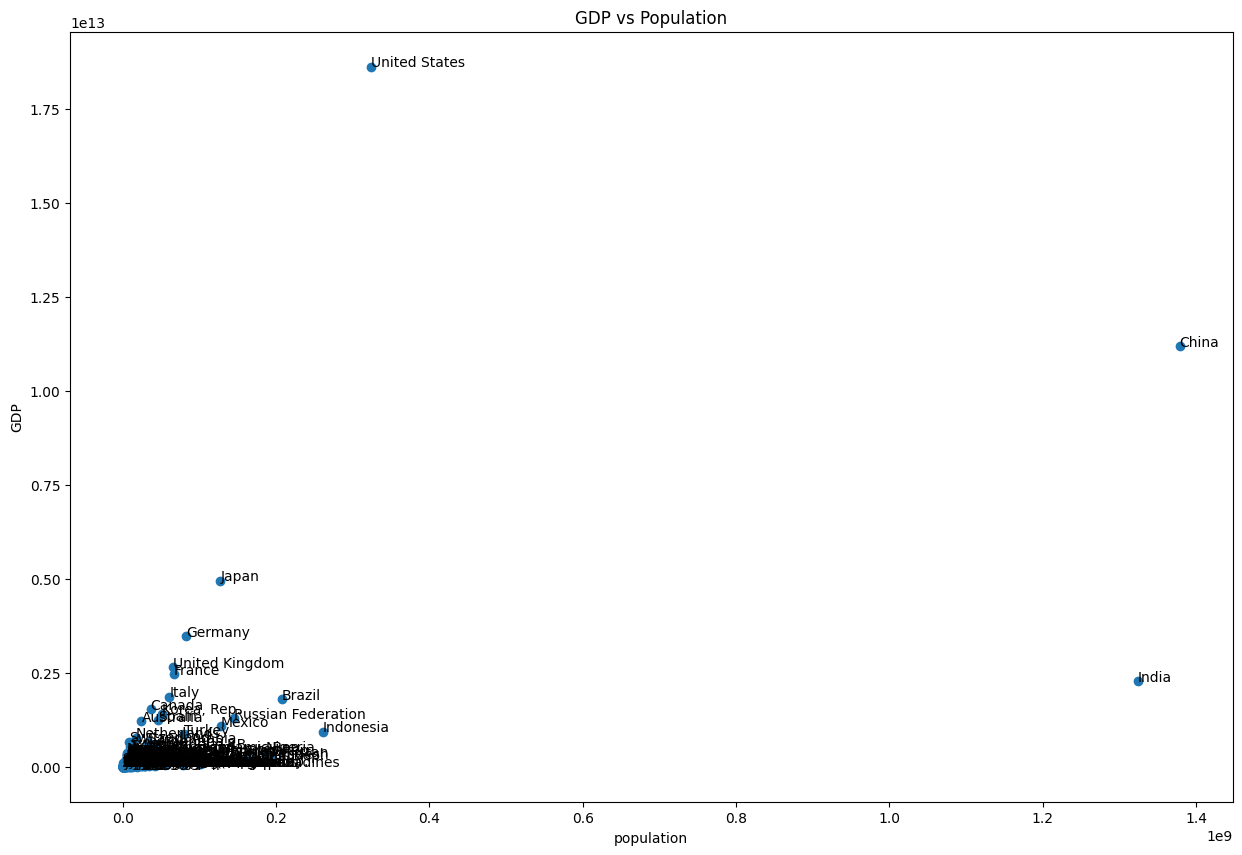

In [28]:
x = list(df_2016['population'])
y = list(df_2016['gdp'])
text = df_2016['Country Name']

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x, y)
plt.title('GDP vs Population')
plt.xlabel('population')
plt.ylabel('GDP')
for i, txt in enumerate(text):
    ax.annotate(txt, (x[i],y[i]))

В США, Китае и Индии значения настолько велики, что остальные данные трудно рассмотреть.

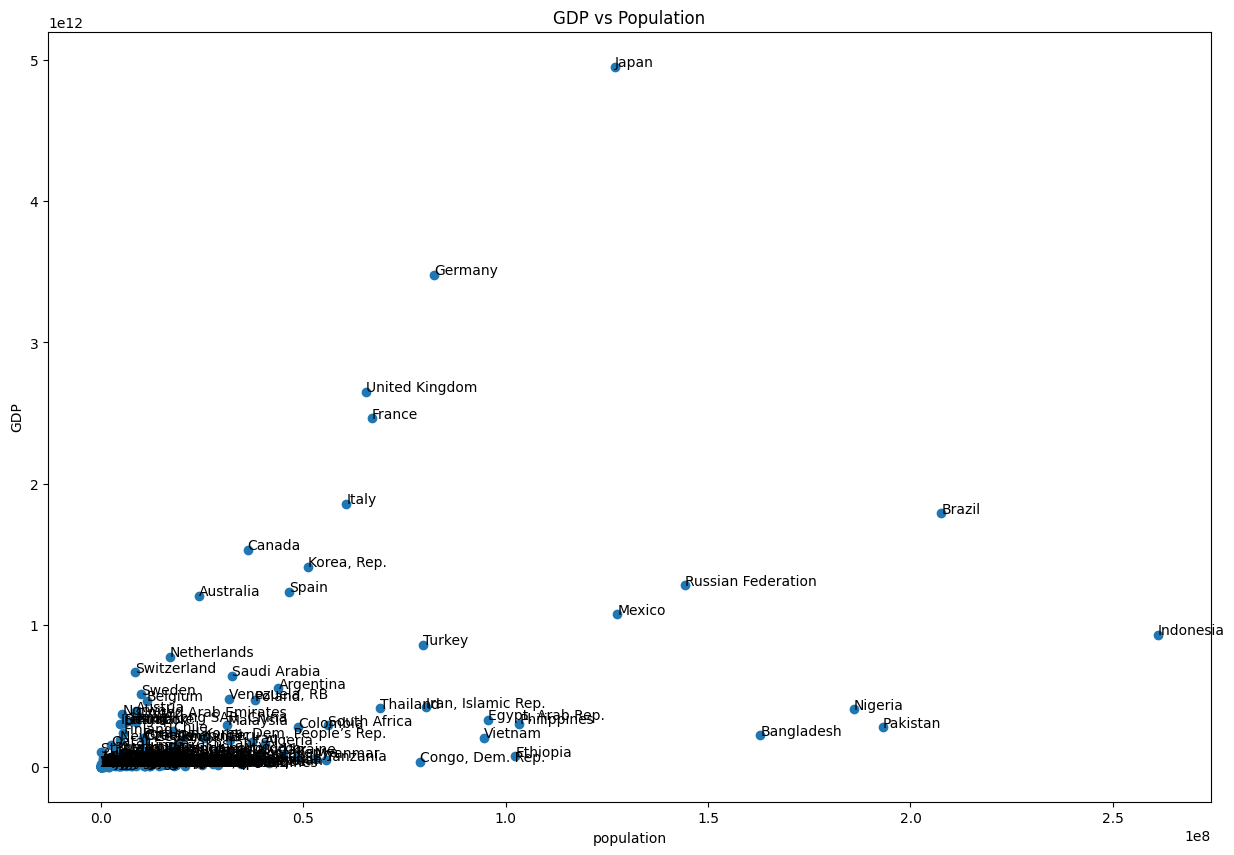

In [29]:
df_no_large = (df_2016['Country Name'] != 'United States') & (df_2016['Country Name'] != 'India') & (df_2016['Country Name'] != 'China')
x = list(df_2016[df_no_large]['population'])
y = list(df_2016[df_no_large]['gdp'])
text = df_2016[df_no_large]['Country Name']

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x, y)
plt.title('GDP vs Population')
plt.xlabel('population')
plt.ylabel('GDP')
for i, txt in enumerate(text):
    ax.annotate(txt, (x[i],y[i]))

# Load 

In this part, I'll load data into different formats: a csv file, a json file, and a SQLite database.

In [39]:
gdp

,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,12044212903.8168,11926953258.916,12890867538.5302,12319784787.2987,12776277515.48,13228244357.1813,11386931489.7968,11883682170.8236,13039352743.9616,Unnamed: 62
0,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09,3.012914e+09,NaN
1,Arab World,ARB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.795820e+12,2.109551e+12,2.501305e+12,2.786139e+12,2.866038e+12,2.906918e+12,2.554480e+12,2.500164e+12,2.591047e+12,NaN
2,United Arab Emirates,ARE,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.535474e+11,2.897873e+11,3.506660e+11,3.745906e+11,3.901076e+11,4.031371e+11,3.581351e+11,3.570451e+11,3.825751e+11,NaN
3,Argentina,ARG,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3.329765e+11,4.236274e+11,5.301633e+11,5.459824e+11,5.520251e+11,5.263197e+11,5.947493e+11,5.548609e+11,6.375904e+11,NaN
4,Armenia,ARM,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8.647937e+09,9.260285e+09,1.014211e+10,1.061932e+10,1.112147e+10,1.160951e+10,1.055334e+10,1.054614e+10,1.153659e+10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,Kosovo,XKX,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,5.653793e+09,5.829934e+09,6.686683e+09,6.500193e+09,7.073420e+09,7.386891e+09,6.439947e+09,6.715487e+09,7.128691e+09,NaN
256,"Yemen, Rep.",YEM,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.513027e+10,3.090675e+10,3.272642e+10,3.540133e+10,4.041524e+10,4.322858e+10,3.460248e+10,1.821333e+10,NaN,NaN
257,South Africa,ZAF,GDP (current US$),NY.GDP.MKTP.CD,7.575248e+09,7.972841e+09,8.497830e+09,9.423212e+09,1.037379e+10,1.133417e+10,...,2.972167e+11,3.752981e+11,4.168782e+11,3.963327e+11,3.668294e+11,3.509046e+11,3.177410e+11,2.957627e+11,3.494193e+11,NaN
258,Zambia,ZMB,GDP (current US$),NY.GDP.MKTP.CD,7.130000e+08,6.962857e+08,6.931429e+08,7.187143e+08,8.394286e+08,1.082857e+09,...,1.532834e+10,2.026556e+10,2.346010e+10,2.550337e+10,2.804546e+10,2.715063e+10,2.115439e+10,2.095475e+10,2.580867e+10,NaN


In [45]:
gdp['Country Name']

0             Aruba
1       Afghanistan
2            Angola
3           Albania
4           Andorra
           ...     
259          Kosovo
260     Yemen, Rep.
261    South Africa
262          Zambia
263        Zimbabwe
Name: Country Name, Length: 264, dtype: object

In [56]:
population

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,supplementprojectflg,productlinetype,projectstatusdisplay,status,...,mjsector,theme1,Official Country Name,Country Code,approvalyear,approvalday,approvalweekday,closingyear,closingday,closingweekday
0,P162228,Other,World;World,RE,Investment Project Financing,IN,N,L,Active,Active,...,NaN,!$!0,World,WLD,2018.0,2018.0,2018.0,NaN,NaN,NaN
1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Investment Project Financing,IN,N,L,Active,Active,...,NaN,!$!0,Democratic Republic of the Congo,COD,2018.0,2018.0,2018.0,2023.0,2023.0,2023.0
2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,PE,Investment Project Financing,IN,Y,L,Active,Active,...,NaN,!$!0,People's Republic of Bangladesh,BGD,2018.0,2018.0,2018.0,NaN,NaN,NaN
3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Investment Project Financing,IN,N,L,Active,Active,...,NaN,!$!0,Islamic Republic of Afghanistan,AFG,2018.0,2018.0,2018.0,2023.0,2023.0,2023.0
4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,N,L,Active,Active,...,Social Protection;Social Protection;Industry; ...,!$!0,Federal Republic of Nigeria,NGA,2018.0,2018.0,2018.0,2023.0,2023.0,2023.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17414,P006578,Latin America and Caribbean,Republic of Chile;Republic of Chile,PE,Specific Investment Loan,IN,N,L,Closed,Closed,...,(Historic)Electric Power & Other Energy;(Histo...,!$!0,Republic of Chile,CHL,1948.0,1948.0,1948.0,1954.0,1954.0,1954.0
17415,P037451,Europe and Central Asia,Grand Duchy of Luxembourg;Grand Duchy of Luxem...,PE,Structural Adjustment Loan,AD,N,L,Closed,Closed,...,(Historic)Multisector;(Historic)Multisector,!$!0,Grand Duchy of Luxembourg,LUX,1947.0,1947.0,1947.0,1949.0,1949.0,1949.0
17416,P037362,Europe and Central Asia,Kingdom of Denmark;Kingdom of Denmark,PE,Structural Adjustment Loan,AD,N,L,Closed,Closed,...,(Historic)Multisector;(Historic)Multisector,!$!0,Kingdom of Denmark,DNK,1947.0,1947.0,1947.0,1949.0,1949.0,1949.0
17417,P037452,Europe and Central Asia,Kingdom of the Netherlands;Kingdom of the Neth...,PE,Structural Adjustment Loan,AD,N,L,Closed,Closed,...,(Historic)Multisector;(Historic)Multisector,!$!0,Kingdom of the Netherlands,NLD,1947.0,1947.0,1947.0,1948.0,1948.0,1948.0


In [61]:
df_projects

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,supplementprojectflg,productlinetype,projectstatusdisplay,status,...,theme1,Official Country Name,Country Code,approvalyear,approvalday,approvalweekday,closingyear,closingday,closingweekday,year
0,P162228,Other,World;World,RE,Investment Project Financing,IN,N,L,Active,Active,...,!$!0,World,WLD,2018.0,2018.0,2018.0,NaN,NaN,NaN,2018.0
1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Investment Project Financing,IN,N,L,Active,Active,...,!$!0,Democratic Republic of the Congo,COD,2018.0,2018.0,2018.0,2023.0,2023.0,2023.0,2018.0
2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,PE,Investment Project Financing,IN,Y,L,Active,Active,...,!$!0,People's Republic of Bangladesh,BGD,2018.0,2018.0,2018.0,NaN,NaN,NaN,2018.0
3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Investment Project Financing,IN,N,L,Active,Active,...,!$!0,Islamic Republic of Afghanistan,AFG,2018.0,2018.0,2018.0,2023.0,2023.0,2023.0,2018.0
4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,N,L,Active,Active,...,!$!0,Federal Republic of Nigeria,NGA,2018.0,2018.0,2018.0,2023.0,2023.0,2023.0,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17414,P006578,Latin America and Caribbean,Republic of Chile;Republic of Chile,PE,Specific Investment Loan,IN,N,L,Closed,Closed,...,!$!0,Republic of Chile,CHL,1948.0,1948.0,1948.0,1954.0,1954.0,1954.0,1948.0
17415,P037451,Europe and Central Asia,Grand Duchy of Luxembourg;Grand Duchy of Luxem...,PE,Structural Adjustment Loan,AD,N,L,Closed,Closed,...,!$!0,Grand Duchy of Luxembourg,LUX,1947.0,1947.0,1947.0,1949.0,1949.0,1949.0,1947.0
17416,P037362,Europe and Central Asia,Kingdom of Denmark;Kingdom of Denmark,PE,Structural Adjustment Loan,AD,N,L,Closed,Closed,...,!$!0,Kingdom of Denmark,DNK,1947.0,1947.0,1947.0,1949.0,1949.0,1949.0,1947.0
17417,P037452,Europe and Central Asia,Kingdom of the Netherlands;Kingdom of the Neth...,PE,Structural Adjustment Loan,AD,N,L,Closed,Closed,...,!$!0,Kingdom of the Netherlands,NLD,1947.0,1947.0,1947.0,1948.0,1948.0,1948.0,1947.0


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# read in the projects data set and do basic wrangling 
gdp = pd.read_csv('data/clear_data/gdp_data.csv')
gdp.drop(['Unnamed: 62', 'Indicator Name', 'Indicator Code'], inplace=True, axis=1)
population = pd.read_csv('data/clear_data/population_data.csv')
population.drop(['Unnamed: 62', 'Indicator Name', 'Indicator Code'], inplace=True, axis=1)


# Reshape the data sets so that they are in long format
gdp_melt = gdp.melt(id_vars=['Country Name', 'Country Code'], 
                    var_name='year',
                    value_name='gdp')

# Use back fill and forward fill to fill in missing gdp values
gdp_melt['gdp'] = gdp_melt.sort_values('year').groupby(['Country Name', 'Country Code'])['gdp'].fillna(method='ffill').fillna(method='bfill')

population_melt = population.melt(id_vars=['Country Name', 'Country Code'], 
                                  var_name='year', 
                                  value_name='population')

# Use back fill and forward fill to fill in missing population values
population_melt['population'] = population_melt.sort_values('year').groupby('Country Name')['population'].fillna(method='ffill').fillna(method='bfill')

# merge the population and gdp data together into one data frame
df_indicator = gdp_melt.merge(population_melt, on=('Country Name', 'Country Code', 'year'))


# remove non countries from the data
df_indicator  = df_indicator[~df_indicator['Country Name'].isin(non_countries)]
df_indicator.reset_index(inplace=True, drop=True)

df_indicator.columns = ['countryname', 'countrycode', 'year', 'gdp', 'population']

# output the first few rows of the data frame
df_indicator.head()

/tmp/ipykernel_1929/3762508294.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_melt['gdp'] = gdp_melt.sort_values('year').groupby(['Country Name', 'Country Code'])['gdp'].fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_1929/3762508294.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  population_melt['population'] = population_melt.sort_values('year').groupby('Country Name')['population'].fillna(method='ffill').fillna(method='bfill')


,countryname,countrycode,year,gdp,population
0,Aruba,ABW,1960,1.916242e+09,54211.0
1,Afghanistan,AFG,1960,5.377778e+08,8996351.0
2,Angola,AGO,1960,1.857319e+10,5643182.0
3,Albania,ALB,1960,1.857319e+10,1608800.0
4,Andorra,AND,1960,1.857319e+10,13411.0


In [64]:
df_indicator

,countryname,countrycode,year,gdp,population
0,Aruba,ABW,1960,1.916242e+09,54211.0
1,Afghanistan,AFG,1960,5.377778e+08,8996351.0
2,Angola,AGO,1960,1.857319e+10,5643182.0
3,Albania,ALB,1960,1.857319e+10,1608800.0
4,Andorra,AND,1960,1.857319e+10,13411.0
...,...,...,...,...,...
12581,Kosovo,XKX,2017,7.128691e+09,1830700.0
12582,"Yemen, Rep.",YEM,2017,1.821333e+10,28250420.0
12583,South Africa,ZAF,2017,3.494193e+11,56717156.0
12584,Zambia,ZMB,2017,2.580867e+10,17094130.0


Run this code cell to read in the countries data set. This will create a data frame called df_projects containing the World Bank projects data. The data frame only has the 'id', 'countryname', 'countrycode', 'totalamt', and 'year' columns.

In [65]:
# read in the projects data set with all columns type string
df_projects = pd.read_csv('data/preprocess_data/projects_data_Country_Date_repair.csv', dtype=str)


df_projects['countryname'] = df_projects['countryname'].str.split(';').str.get(0)

# set up the libraries and variables

country_not_found = [] # stores countries not found in the pycountry library
project_country_abbrev_dict = defaultdict(str) # set up an empty dictionary of string values

# iterate through the country names in df_projects. 
# Create a dictionary mapping the country name to the alpha_3 ISO code
for country in df_projects['countryname'].drop_duplicates().sort_values():
    try: 
        # look up the country name in the pycountry library
        # store the country name as the dictionary key and the ISO-3 code as the value
        project_country_abbrev_dict[country] = countries.lookup(country).alpha_3
    except:
        # If the country name is not in the pycountry library, then print out the country name
        # And store the results in the country_not_found list
        country_not_found.append(country)
        
# run this code cell to load the dictionary

country_not_found_mapping = {'Co-operative Republic of Guyana': 'GUY',
             'Commonwealth of Australia':'AUS',
             'Democratic Republic of Sao Tome and Prin':'STP',
             'Democratic Republic of the Congo':'COD',
             'Democratic Socialist Republic of Sri Lan':'LKA',
             'East Asia and Pacific':'EAS',
             'Europe and Central Asia': 'ECS',
             'Islamic  Republic of Afghanistan':'AFG',
             'Latin America':'LCN',
              'Caribbean':'LCN',
             'Macedonia':'MKD',
             'Middle East and North Africa':'MEA',
             'Oriental Republic of Uruguay':'URY',
             'Republic of Congo':'COG',
             "Republic of Cote d'Ivoire":'CIV',
             'Republic of Korea':'KOR',
             'Republic of Niger':'NER',
             'Republic of Kosovo':'XKX',
             'Republic of Rwanda':'RWA',
              'Republic of The Gambia':'GMB',
              'Republic of Togo':'TGO',
              'Republic of the Union of Myanmar':'MMR',
              'Republica Bolivariana de Venezuela':'VEN',
              'Sint Maarten':'SXM',
              "Socialist People's Libyan Arab Jamahiriy":'LBY',
              'Socialist Republic of Vietnam':'VNM',
              'Somali Democratic Republic':'SOM',
              'South Asia':'SAS',
              'St. Kitts and Nevis':'KNA',
              'St. Lucia':'LCA',
              'St. Vincent and the Grenadines':'VCT',
              'State of Eritrea':'ERI',
              'The Independent State of Papua New Guine':'PNG',
              'West Bank and Gaza':'PSE',
              'World':'WLD'}

project_country_abbrev_dict.update(country_not_found_mapping)

df_projects['countrycode'] = df_projects['countryname'].apply(lambda x: project_country_abbrev_dict[x])

df_projects['boardapprovaldate'] = pd.to_datetime(df_projects['boardapprovaldate'])

df_projects['year'] = df_projects['boardapprovaldate'].dt.year.astype(str).str.slice(stop=4)

df_projects['totalamt'] = pd.to_numeric(df_projects['totalamt'].str.replace(',',""))

df_projects = df_projects[['id', 'countryname', 'countrycode', 'totalamt', 'year']]

df_projects.head()

,id,countryname,countrycode,totalamt,year
0,P162228,World,WLD,0,2018
1,P163962,Democratic Republic of the Congo,COD,200000000,2018
2,P167672,People's Republic of Bangladesh,BGD,58330000,2018
3,P158768,Islamic Republic of Afghanistan,AFG,20000000,2018
4,P161364,Federal Republic of Nigeria,NGA,100000000,2018


In [66]:
df_merged = df_projects.merge(df_indicator, how='left', on=['countrycode', 'year'])

In [67]:
df_merged[(df_merged['year'] == '2017') & (df_merged['countryname_y'] == 'Jordan')]

,id,countryname_x,countrycode,totalamt,year,countryname_y,gdp,population
241,P161982,Hashemite Kingdom of Jordan,JOR,0,2017,Jordan,4.006831e+10,9702353.0
284,P162407,Hashemite Kingdom of Jordan,JOR,147700000,2017,Jordan,4.006831e+10,9702353.0
301,P160103,Hashemite Kingdom of Jordan,JOR,0,2017,Jordan,4.006831e+10,9702353.0
436,P161905,Hashemite Kingdom of Jordan,JOR,50000000,2017,Jordan,4.006831e+10,9702353.0
467,P163387,Hashemite Kingdom of Jordan,JOR,36100000,2017,Jordan,4.006831e+10,9702353.0
487,P163241,Hashemite Kingdom of Jordan,JOR,0,2017,Jordan,4.006831e+10,9702353.0


In [69]:
df_merged.to_csv('data/preprocess_data/result_not_end.csv', index=False)

> ## Немного выводов

1. Данные следует почистить от стран, которые не являются странами (например: `World`)
2. Нужно обработать тип данных `DateTime`
3. Также необходимо перевести числовые значения формата `103,101` в формат `103101`
4. Исходя из результатов построим финальную таблицу в которой будут содержаться по годам данные разных экономических и макроэкономических параметров стран